Machine Learning

###**Determining housing prices in Tashkent city.**

In [51]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')
df.head()

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57,4,4,52000
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52,4,5,56000
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42,4,4,37000
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65,1,4,49500
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70,3,5,55000


# **Column Descriptions**

* `location` – address of the house for sale
* `district` – district where the house is located
* `rooms` – number of rooms
* `size` – house area (sq.m)
* `level` – floor on which the house is located
* `max_levels` – total number of floors
* `price` – house price

## **The task was completed using the CRISP-DM methodology.**

<img src="https://i.imgur.com/dzZnnYi.png" alt="CRISP-DM" width="800"/>

# **Libraries to be imported for the project**


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   location    7565 non-null   object
 1   district    7565 non-null   object
 2   rooms       7565 non-null   int64 
 3   size        7565 non-null   object
 4   level       7565 non-null   int64 
 5   max_levels  7565 non-null   int64 
 6   price       7565 non-null   object
dtypes: int64(3), object(4)
memory usage: 413.8+ KB


**I dropped the `location` column because the `district` column already exists, and since it is a string, it is not unique.**


In [5]:
df.drop('location', axis=1, inplace=True)

**Converting object columns to numeric and checking whether there is correlation between them.**


In [24]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce')
data = df.drop('district', axis=1)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rooms       7565 non-null   int64  
 1   size        7564 non-null   float64
 2   level       7565 non-null   int64  
 3   max_levels  7565 non-null   int64  
 4   price       7466 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 295.6 KB


**To achieve better correlation, and from an engineering perspective, the building’s floor-related features should have good correlation, which helps the model perform better.**


In [34]:
data['floor_ratio'] = df['level'] / df['max_levels']
data['is_top_floor'] = (df['level'] == df['max_levels']).astype(int)



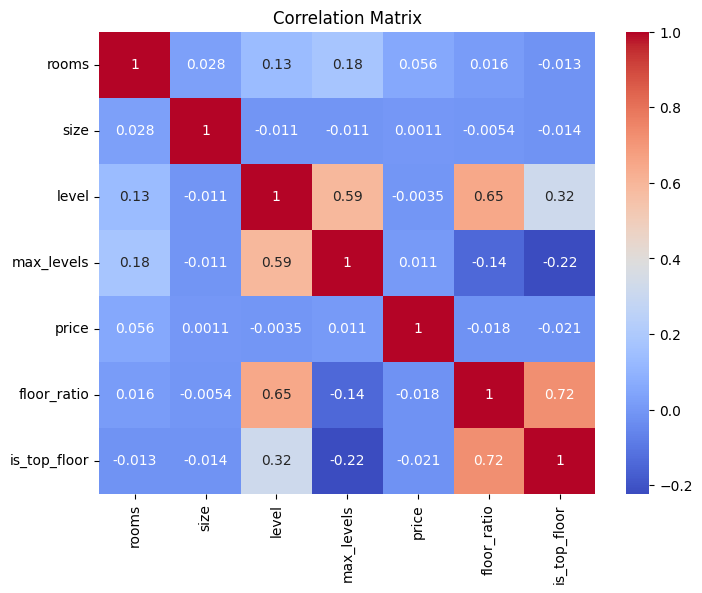

In [35]:
corr_matrix = data.corr()
corr_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

#DATA cleaning process

### **We load the data and convert it into numeric format.**


In [205]:
df = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')
#Correctly cleaning the `price` and `size` columns.**

df['price'] = (
    df['price']
    .str.replace(r'[^0-9.]', '', regex=True)
)

df['size'] = (
    df['size']
    .str.replace(r'[^0-9.]', '', regex=True)
)

df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce')

# ❗ We drop rows where the TARGET value is NaN.**

df = df.dropna(subset=['price'])

# The location column is unnecessary.
df = df.drop(columns=['location'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7466 entries, 0 to 7564
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   district    7466 non-null   object 
 1   rooms       7466 non-null   int64  
 2   size        7466 non-null   float64
 3   level       7466 non-null   int64  
 4   max_levels  7466 non-null   int64  
 5   price       7466 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 408.3+ KB


### **We split the data into training and testing sets.**

In [196]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    df, test_size=0.2, random_state=42
)

X_train = train_set.drop('price', axis=1)
y_train = train_set['price'].copy()

**We build a pipeline.**


In [197]:
class FloorFeatureAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convert X to a NumPy array to allow direct positional slicing
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        level = X_array[:, 0].astype(float)
        max_levels = X_array[:, 1].astype(float)

        # For safety purposes.
        floor_ratio = np.divide(
            level,
            max_levels,
            out=np.zeros_like(level),
            where=max_levels != 0
        )

        is_top_floor = ((level == max_levels) & (max_levels != 0)).astype(int)

        return np.c_[floor_ratio, is_top_floor]


In [198]:
num_simple = ['rooms', 'size']
num_floor = ['level', 'max_levels']
cat_features = ['district']


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


floor_pipeline = Pipeline([
    ('floor_features', FloorFeatureAdder()),
    ('scaler', StandardScaler())
])


cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_simple),
    ('floor', floor_pipeline, num_floor),
    ('cat', cat_pipeline, cat_features)
])

In [199]:
X_prepared = full_pipeline.fit_transform(X_train)

In [200]:
X_prepared.shape


(5972, 16)

#Machine Learning

###Linear Regression

In [201]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()

In [202]:
LR_model.fit(X_prepared, y_train)

LinearRegression()

In [203]:
# We randomly select 5 rows.
test_data = X_train.sample(5)
test_data

,district,rooms,size,level,max_levels
5559,Яшнободский,4,136.0,1,9
832,Учтепинский,2,53.0,5,5
2218,Учтепинский,1,42.0,4,5
2653,Мирзо-Улугбекский,1,17.0,2,4
708,Мирзо-Улугбекский,2,60.0,4,4


In [206]:
test_label = y_train.loc[test_data.index]
test_label

,price
5559,85000.0
832,32000.0
2218,25500.0
2653,17000.0
708,32000.0


In [207]:
test_data_prepared = full_pipeline.transform(test_data)
test_data_prepared

array([[ 1.27065421,  0.01785778, -1.84216993, -0.55181499,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.57073064, -0.04099267,  1.31123281,  1.81220159,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.49142306, -0.04879213,  0.6017172 , -0.55181499,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.49142306, -0.06651817, -0.46255623, -0.55181499,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.57073064, -0.03602938,  1

In [208]:
predicted_data = LR_model.predict(test_data_prepared)
predicted_data

array([90893.41684417, 14920.31638551, 13523.55469935, 26649.64578572,
       30132.03789559])

Yuoqirda ko'rib turganingiz bashorat qilingan qiymatlar. Xo'sh, ular real qiymatlardan qanday farq qiladi, solishtiramiz:

In [209]:
pd.DataFrame({'Predicted':predicted_data, 'Actual prices.': test_label})

,Prognoz,Real baxosi
5559,90893.416844,85000.0
832,14920.316386,32000.0
2218,13523.554699,25500.0
2653,26649.645786,17000.0
708,30132.037896,32000.0


**We evaluate the model.**



In [210]:
test_set

,district,rooms,size,level,max_levels,price
2301,Яшнободский,3,86.0,4,9,89000.0
3540,Олмазорский,3,70.0,3,4,41000.0
2149,Яккасарайский,3,90.0,5,5,45000.0
2921,Мирзо-Улугбекский,3,70.0,1,4,72500.0
5642,Янгихаётский,3,70.0,3,9,61900.0
...,...,...,...,...,...,...
5044,Мирзо-Улугбекский,3,65.0,2,5,55500.0
441,Чиланзарский,1,36.0,2,5,28500.0
2498,Юнусабадский,3,70.0,1,9,69000.0
5661,Мирабадский,3,77.6,4,5,65000.0


In [211]:
X_test = test_set.drop('price', axis=1)
X_test

,district,rooms,size,level,max_levels
2301,Яшнободский,3,86.0,4,9
3540,Олмазорский,3,70.0,3,4
2149,Яккасарайский,3,90.0,5,5
2921,Мирзо-Улугбекский,3,70.0,1,4
5642,Янгихаётский,3,70.0,3,9
...,...,...,...,...,...
5044,Мирзо-Улугбекский,3,65.0,2,5
441,Чиланзарский,1,36.0,2,5
2498,Юнусабадский,3,70.0,1,9
5661,Мирабадский,3,77.6,4,5


In [212]:
y_test = test_set['price'].copy()
y_test

,price
2301,89000.0
3540,41000.0
2149,45000.0
2921,72500.0
5642,61900.0
...,...
5044,55500.0
441,28500.0
2498,69000.0
5661,65000.0


In [213]:
X_test_prepared = full_pipeline.transform(X_test)

In [214]:
y_predicted = LR_model.predict(X_test_prepared)

In [215]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_test, y_predicted)
# We calculate RMSE.
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

1351130.7652933656


#DecisionTree

In [217]:
from sklearn.tree import DecisionTreeRegressor
Tree_model = DecisionTreeRegressor()
Tree_model.fit(X_prepared, y_train)

DecisionTreeRegressor()

In [218]:
y_predicted = Tree_model.predict(X_test_prepared)

In [219]:
lin_mse = mean_squared_error(y_test, y_predicted)
# We calculate RMSE.
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

1351102.4992837869


#RandomForest

In [221]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor()
RF_model.fit(X_prepared, y_train)

RandomForestRegressor()

In [222]:
y_predicted = RF_model.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, y_predicted)
# We calculate RMSE.
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

1351999.0676002814
